 ## Loading Data

Imports

In [3]:
import neo
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

### Loading processed data

In [ ]:
# Load .mat file from directory   

In [4]:
# Load the .mat file
data_processed = scipy.io.loadmat('6_Eyes_data.mat')

# Inspect the keys of the loaded dictionary
print(data_processed.keys())

FileNotFoundError: [Errno 2] No such file or directory: '6_Eyes_data.mat'

In [4]:
variable_name = 'ad_stacked_cell_extended_STIMULATION'
df_processed = pd.DataFrame(data_processed[variable_name])

# Print shape and type of the data
print(f"{variable_name} shape: {data_processed[variable_name].shape}") # Access the shape of the array within the dictionary
print(f"Data type: {type(data_processed[variable_name])}")
print(f"Data type details: {data_processed[variable_name].dtype}")

ad_stacked_cell_extended_STIMULATION shape: (6, 32)
Data type: <class 'numpy.ndarray'>
Data type details: object


Normalizing processed data with (0,1)

In [ ]:
all_data = []
for i in range(6):
  eye_data = df_processed.iloc[i]
  # Iterate over each channel
  for channel_idx, channel in enumerate(eye_data):
      for section in channel.T[:, :]:
        for data_point in section:
            all_data.append(data_point)

In [ ]:
all_data_numeric = np.array(all_data, dtype=float)
clean_all_data = all_data_numeric[~np.isnan(all_data_numeric)]
mean = np.mean(clean_all_data)
std = np.std(clean_all_data)

In [ ]:
import numpy as np

df_normalized = df_processed.copy()

# Iterate over the rows of the DataFrame
for i in range(6):
    eye_data = df_normalized.iloc[i]

    # Iterate over each channel
    for channel_idx, channel in enumerate(eye_data):
        # Transpose to iterate over sections
        section = channel.T

        # Create a boolean mask for NaNs
        nan_mask = np.isnan(section)

        # Replace NaNs with the mean
        section[nan_mask] = mean

        # Normalize the data
        section = (section - mean) / std

        # Assign the normalized data back
        df_normalized.iloc[i][channel_idx] = section.T


In [ ]:
print(df_normalized.head())
print(df_processed.head())

### Loading of unproccessed data

In [10]:
# SA data
# Load the ns5 file using the BlackrockIO
filename = '10Hz_1V_neg500mV_1ms003.ns5'
reader = neo.io.BlackrockIO(filename)

# Read the data from the file
block_SA = reader.read_block()

# Since there is only one segment, access it directly
segment_SA = block_SA.segments[0]

# Access the first analog signal within this segment
analog_signal_SA = segment_SA.analogsignals[0]

# Example: Print some information about the signal
print(f"Signal shape: {analog_signal_SA.shape}")
print(f"Signal units: {analog_signal_SA.units}")
print(f"Sampling rate: {analog_signal_SA.sampling_rate}")

# Access the signal data as a NumPy array
data_SA = np.asarray(analog_signal_SA.magnitude)
# print(f"First 10 data points: {data[:10]}")

Signal shape: (300300, 32)
Signal units: 1.0 uV
Sampling rate: 30000.0 Hz


Loading of TTX data

In [ ]:
# Load the ns5 file using the BlackrockIO
filename = '10Hz_1V_neg500mV_1ms_TTX007.ns5'
reader = neo.io.BlackrockIO(filename)

# Read the data from the file
block_TTX = reader.read_block()

# Since there is only one segment, access it directly
segment_TTX = block_TTX.segments[0]

# Access the first analog signal within this segment
analog_signal_TTX = segment_TTX.analogsignals[0]

# Access the signal data as a NumPy array
data_SA = np.asarray(analog_signal_SA.magnitude)
# print(f"First 10 data points: {data[:10]}")

 ## Function for identifying spikes


In [7]:
def find_spike_indices(eye_data, processed = True):
    """
    Function to find the indices of spikes in each channel of the given eye_data.

    Parameters:
        eye_data (pd.Series): A series containing the data for each channel.

    Returns:
        pd.DataFrame: A DataFrame where each column corresponds to a channel and
                      contains the list of spike indices (section, index) for that channel.
    """

    spike_indices = []  # List to store spike indices for each channel

    # Iterate over each channel
    for channel_idx, channel in enumerate(eye_data):
        channel_spike_indices = []  # List to store spike indices for the current channel

        if processed == False:
            channel = channel[:,np.newaxis]

        for section_idx, section in enumerate(channel.T[:, :]):  # Transpose to iterate over columns
            # Compute the threshold for the current section
            threshold = np.sqrt(np.mean(np.square(section), axis=0)) * 4.5

            detention = 0
            first_spike = True  # Flag to handle the first spike

            # Iterate over each data point in the section
            for i, data_point in enumerate(section):
                if first_spike:
                    if data_point > threshold:
                        # Look at the next 30 data points or until the end of the section
                        look_ahead_end = min(i + 30, len(section))
                        look_ahead_data = section[i:look_ahead_end]

                        # Find the index of the maximum value in the look-ahead window
                        max_index = np.argmax(look_ahead_data) + i  # Add i to get the correct index in the original section

                        # Append the index of the maximum value
                        channel_spike_indices.append((section_idx, i, max_index))

                        first_spike = False
                        detention = 0
                else:
                    if data_point > threshold and detention > 30:
                        # Look at the next 30 data points or until the end of the section
                        look_ahead_end = min(i + 30, len(section))
                        look_ahead_data = section[i:look_ahead_end]

                        # Find the index of the maximum value in the look-ahead window
                        max_index = np.argmax(look_ahead_data) + i  # Add i to get the correct index in the original section

                        # Append the index of the maximum value
                        channel_spike_indices.append((section_idx, i, max_index))

                        detention = 0
                    else:
                        detention += 1

        # Store the spike indices for the current channel
        spike_indices.append(channel_spike_indices)

    # print spikes indices
    # for idx, spikes in enumerate(spike_indices):
        # print(f"Spike indices for channel {idx + 1}: {spikes}")

    return spike_indices

In [33]:
# Example usage processed data
eye_data_processed = df_processed.iloc[0]
spike_indices_processed = find_spike_indices(eye_data_processed, processed = True)

In [11]:
# Example usage unprocessed data
eye_data_unprocessed = data_SA.T
spike_indices_unprocessed = find_spike_indices(eye_data_unprocessed, processed = False)

In [24]:
def plot_spikes_with_data_processed(eye_data, channel_idx, section_idx, spike_indices):
    # Extract the data for the specific channel and section
    channel = eye_data[channel_idx]
    section = channel.T[section_idx, :]  # Extract the specific section data

    # Extract the spike indices for the specific section
    spike_points = [tup[2] for tup in spike_indices[channel_idx] if tup[0] == section_idx]
    print(spike_points)

    # Plot the data series
    plt.figure(figsize=(10, 6))
    plt.plot(section, label=f'Channel {channel_idx + 1}, Section {section_idx + 1}', color='blue')

    # Overlay the spikes with red dots
    plt.scatter(spike_points, section[spike_points], color='red', label='Spikes', zorder=5)

    # Set plot labels and title
    plt.xlabel('Data Point Index')
    plt.ylabel('Amplitude')
    plt.title(f'Processed Data Series with Spikes for Channel {channel_idx + 1}, Section {section_idx + 1}')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

[811, 2052, 2131]


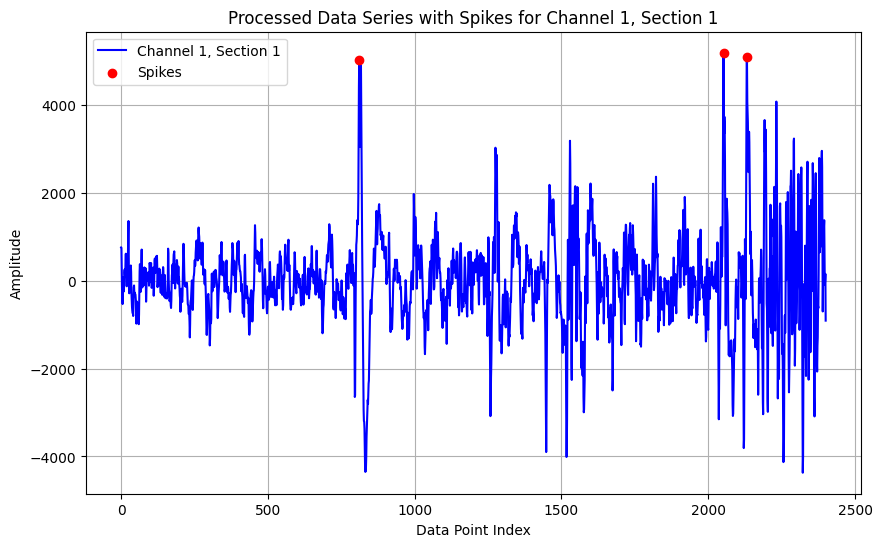

In [25]:
plot_spikes_with_data_processed(eye_data_processed, 0, 0, spike_indices_processed)

In [30]:
def plot_spikes_with_data_unprocessed(eye_data, channel_idx, section_idx, spike_indices, num_points=None):
    # Extract the data for the specific channel and section
    channel = eye_data[channel_idx]
    channel = channel[:, np.newaxis]
    section = channel.T[section_idx, :]  # Extract the specific section data

    # Extract the spike indices for the specific section
    spike_points = [tup[2] for tup in spike_indices[channel_idx] if tup[0] == section_idx]

    # If num_points is specified, limit the section and spike points
    if num_points is not None:
        section = section[:num_points]
        spike_points = [sp for sp in spike_points if sp < num_points]

    # Plot the data series
    plt.figure(figsize=(10, 6))
    plt.plot(section, label=f'Channel {channel_idx + 1}, Section {section_idx + 1}', color='blue')

    # Overlay the spikes with red dots
    # plt.scatter(spike_points, section[spike_points], color='red', label='Spikes', zorder=5)

    # Set plot labels and title
    plt.xlabel('Data Point Index')
    plt.ylabel('Amplitude')
    plt.title(f'Unprocessed Data Series with Spikes for Channel {channel_idx + 1}, Section {section_idx + 1}')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()


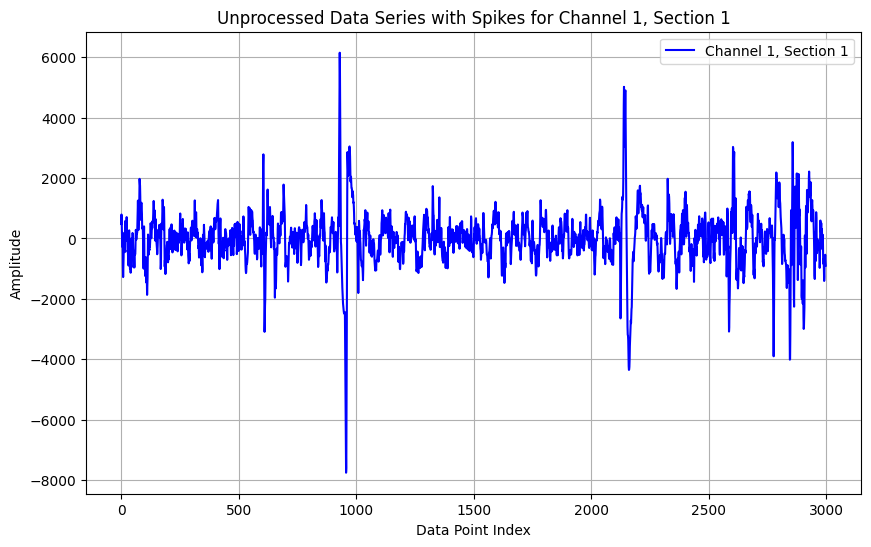

In [31]:
plot_spikes_with_data_unprocessed(eye_data_unprocessed, 0, 0, spike_indices_unprocessed, num_points=3000)

## Processed data exploration


### true spike count

In [ ]:
# Inspection of true spike count
variable_name = 'true_Spike_counts_pr_sec_mat_STIMULATION'
df_processed = pd.DataFrame(data_processed[variable_name])
df_processed

,0,1,2,3,4,5
0,297.50,188.75,126.25,11.25,95.00,1.25
1,296.25,198.75,123.75,13.75,96.25,36.25
2,313.75,186.25,135.00,5.00,91.25,1.25
3,293.75,187.50,123.75,17.50,85.00,58.75
4,293.75,192.50,160.00,12.50,91.25,3.75
5,246.25,192.50,127.50,50.00,100.00,7.50
6,313.75,188.75,131.25,186.25,91.25,43.75
7,305.00,195.00,121.25,40.00,95.00,3.75
8,236.25,193.75,126.25,17.50,93.75,27.50
9,307.50,188.75,131.25,8.75,92.50,0.00


In [ ]:
variable_name = 'ad_stacked_cell_extended_STIMULATION'
df_processed = pd.DataFrame(data_processed[variable_name])

# Print shape and type of the data
print(f"{variable_name} shape: {data_processed[variable_name].shape}") # Access the shape of the array within the dictionary
print(f"Data type: {type(data_processed[variable_name])}")
print(f"Data type details: {data_processed[variable_name].dtype}")

ad_stacked_cell_extended_STIMULATION shape: (6, 32)
Data type: <class 'numpy.ndarray'>
Data type details: object


### Spike count data


In [ ]:
# Defining which eye
eye_data = df_normalized.iloc[0]

spike_count = np.zeros(len(eye_data))  # Array to store spike counts for each channel

# Iterate over each channel
for channel_idx, channel in enumerate(eye_data):
    count = 0

    #threshold = np.sqrt(np.mean(np.square(channel[:,:99]))) * 4.5
    for section in channel.T[:, :]:  # Transpose to iterate over columns

        # Compute the threshold for the current section
        threshold = np.sqrt(np.mean(np.square(section), axis=0)) * 4.5

        detention = 0
        first_spike = True  # Flag to handle the first spike

        # Iterate over each data point in the section
        for data_point in section:
            if first_spike:
                if data_point > threshold:
                    count += 1
                    first_spike = False
                    detention = 0
            else:
                if data_point > threshold and detention > 30:
                    count += 1
                    detention = 0
                else:
                    detention += 1

    # Store the spike count for the current channel
    spike_count[channel_idx] = count

print("Spike counts for each channel:", spike_count)



Spike counts for each channel: [ 43.  41. 211.  46.  42. 143.  45.  42. 181.  45.  43.  42.  44. 193.
  45.  47. 205.  39.  46.  45.  45.  46.  44. 200.  42.  45. 161.   7.
  47. 197. 182.  41.]


Mean spike count per channel per second

In [ ]:
# assuming we only use count the 2400 data points and not 3000
ratio = ((24000 / 30000)*10)
print(f"Ration used: {ratio}")
spike_count_per_channel_per_second = spike_count / ratio
spike_count_per_channel_per_second

Ration used: 8.0


array([ 5.375,  5.125, 26.375,  5.75 ,  5.25 , 17.875,  5.625,  5.25 ,
       22.625,  5.625,  5.375,  5.25 ,  5.5  , 24.125,  5.625,  5.875,
       25.625,  4.875,  5.75 ,  5.625,  5.625,  5.75 ,  5.5  , 25.   ,
        5.25 ,  5.625, 20.125,  0.875,  5.875, 24.625, 22.75 ,  5.125])

In [ ]:
experiment_lenght_in_seconds = 10
spike_count_per_channel_per_second = np.mean(spike_count) / experiment_lenght_in_seconds
print("Spike count for per channel per second:", spike_count_per_channel_per_second)

Spike count for per channel per second: 8.265625


In [ ]:
# Defining which eye (first row) and extracting the first channel
eye_data = df_processed.iloc[0]
first_channel = eye_data[0]

# Extract the first section of the first channel
first_section = first_channel[:, 0]  # Assuming sections are along the columns

# Calculate the threshold for the first section
threshold = np.sqrt(np.mean(np.square(first_section))) * 4.5

# Plot the data points of the first section and the threshold
plt.figure(figsize=(10, 6))
plt.plot(first_section, label='Data Points')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('First Section of First Channel')
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


IndexError: invalid index to scalar variable.

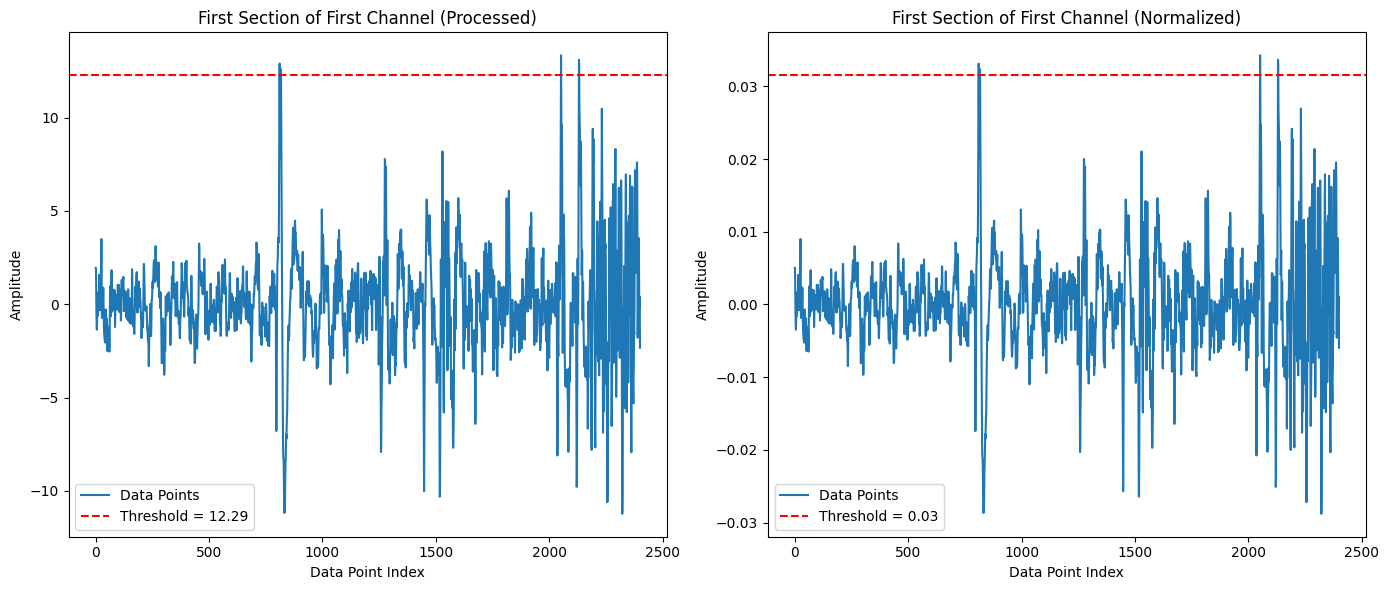

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_processed and df_normalized have similar structures
# Defining which eye (first row) and extracting the first channel
eye_data_processed = df_processed.iloc[0]
eye_data_normalized = df_normalized.iloc[0]

first_channel_processed = eye_data_processed[0]
first_channel_normalized = eye_data_normalized[0]

# Extract the first section of the first channel
first_section_processed = first_channel_processed[:, 0]  # Assuming sections are along the columns
first_section_normalized = first_channel_normalized[:, 0]

# Calculate the threshold for the first section
threshold_processed = np.sqrt(np.mean(np.square(first_section_processed))) * 4.5
threshold_normalized = np.sqrt(np.mean(np.square(first_section_normalized))) * 4.5

# Create subplots
plt.figure(figsize=(14, 6))

# Subplot for df_processed
plt.subplot(1, 2, 1)
plt.plot(first_section_processed, label='Data Points')
plt.axhline(y=threshold_processed, color='r', linestyle='--', label=f'Threshold = {threshold_processed:.2f}')
plt.title('First Section of First Channel (Processed)')
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude')
plt.legend()

# Subplot for df_normalized
plt.subplot(1, 2, 2)
plt.plot(first_section_normalized, label='Data Points')
plt.axhline(y=threshold_normalized, color='r', linestyle='--', label=f'Threshold = {threshold_normalized:.2f}')
plt.title('First Section of First Channel (Normalized)')
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Heat maps

Generate vectors for heat map of spike count

In [ ]:
num_eyes = 6
num_channels = len(df_processed.iloc[0])  # Assuming all eyes have the same number of channels

# Initialize a 2D array to store the spike counts for all eyes and channels
spike_counts_all_eyes = np.zeros((num_eyes, num_channels))

# Iterate over each eye
for i in range(num_eyes):
    eye_data = df_processed.iloc[i]

    # Array to store spike counts for each channel of the current eye
    spike_count = np.zeros(num_channels)

    # Iterate over each channel
    for channel_idx, channel in enumerate(eye_data):
        count = 0

        # Iterate over each section of the current channel
        for section in channel.T[:, :]:  # Transpose to iterate over columns
            # Compute the threshold for the current section
            threshold = np.sqrt(np.mean(np.square(section), axis=0)) * 4.5

            detention = 0
            first_spike = True  # Flag to handle the first spike

            # Iterate over each data point in the section
            for data_point in section:
                if first_spike:
                    if data_point > threshold:
                        count += 1
                        first_spike = False
                        detention = 0
                else:
                    if data_point > threshold and detention > 30:
                        count += 1
                        detention = 0
                    else:
                        detention += 1

        # Store the spike count for the current channel
        spike_count[channel_idx] = count

    # Store the spike counts for the current eye in the 2D array
    spike_counts_all_eyes[i] = spike_count

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_spike_count(data_vector):
    # Convert all vectors to integers and apply modifications
    spike_counts_all_eyes = []
    for vec in data_vector:
        vector = np.asarray(vec, dtype=float)  # Use float for NaN support
        vector = np.insert(vector, 18, np.nan)
        vector = np.insert(vector, 26, np.nan)
        vector = np.concatenate([vector, np.full(6, np.nan)])
        spike_counts_all_eyes.append(vector)

    # Find the maximum value across all spike counts (ignoring NaNs)
    v_max = np.nanmax(np.concatenate(spike_counts_all_eyes))

    # Ensure each vector has exactly 40 elements (5x8 grid + NaN padding)
    matrices = [vec.reshape(5, 8) for vec in spike_counts_all_eyes]

    # Compute the average vector, ignoring NaNs
    average_vector = np.nanmean(spike_counts_all_eyes, axis=0)

    # Reshape the average vector into a 5x8 matrix
    average_matrix = average_vector.reshape(5, 8)

    # Create subplots (keeping 2x4 grid for heatmaps)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns (one extra for the average heatmap)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each heatmap
    for i, ax in enumerate(axes[:-1]):  # Plot all heatmaps except the last one
        if i < len(matrices):
            sns.heatmap(matrices[i].T, ax=ax, annot=True, fmt=".1f", cmap="viridis", cbar=True, vmin=0, vmax=v_max)
            ax.set_title(f'Eye {i+1}')
        else:
            ax.axis('off')  # Hide empty subplots if there are fewer matrices than subplots

    # Plot the average heatmap in the last subplot
    sns.heatmap(average_matrix.T, ax=axes[-1], annot=True, fmt=".1f", cmap="viridis", cbar=True)
    axes[-1].set_title('Average Heatmap for all eyes')

    plt.tight_layout()
    plt.show()


<ipython-input-10-a8a372f6c6c7>:22: RuntimeWarning: Mean of empty slice
  average_vector = np.nanmean(spike_counts_all_eyes, axis=0)


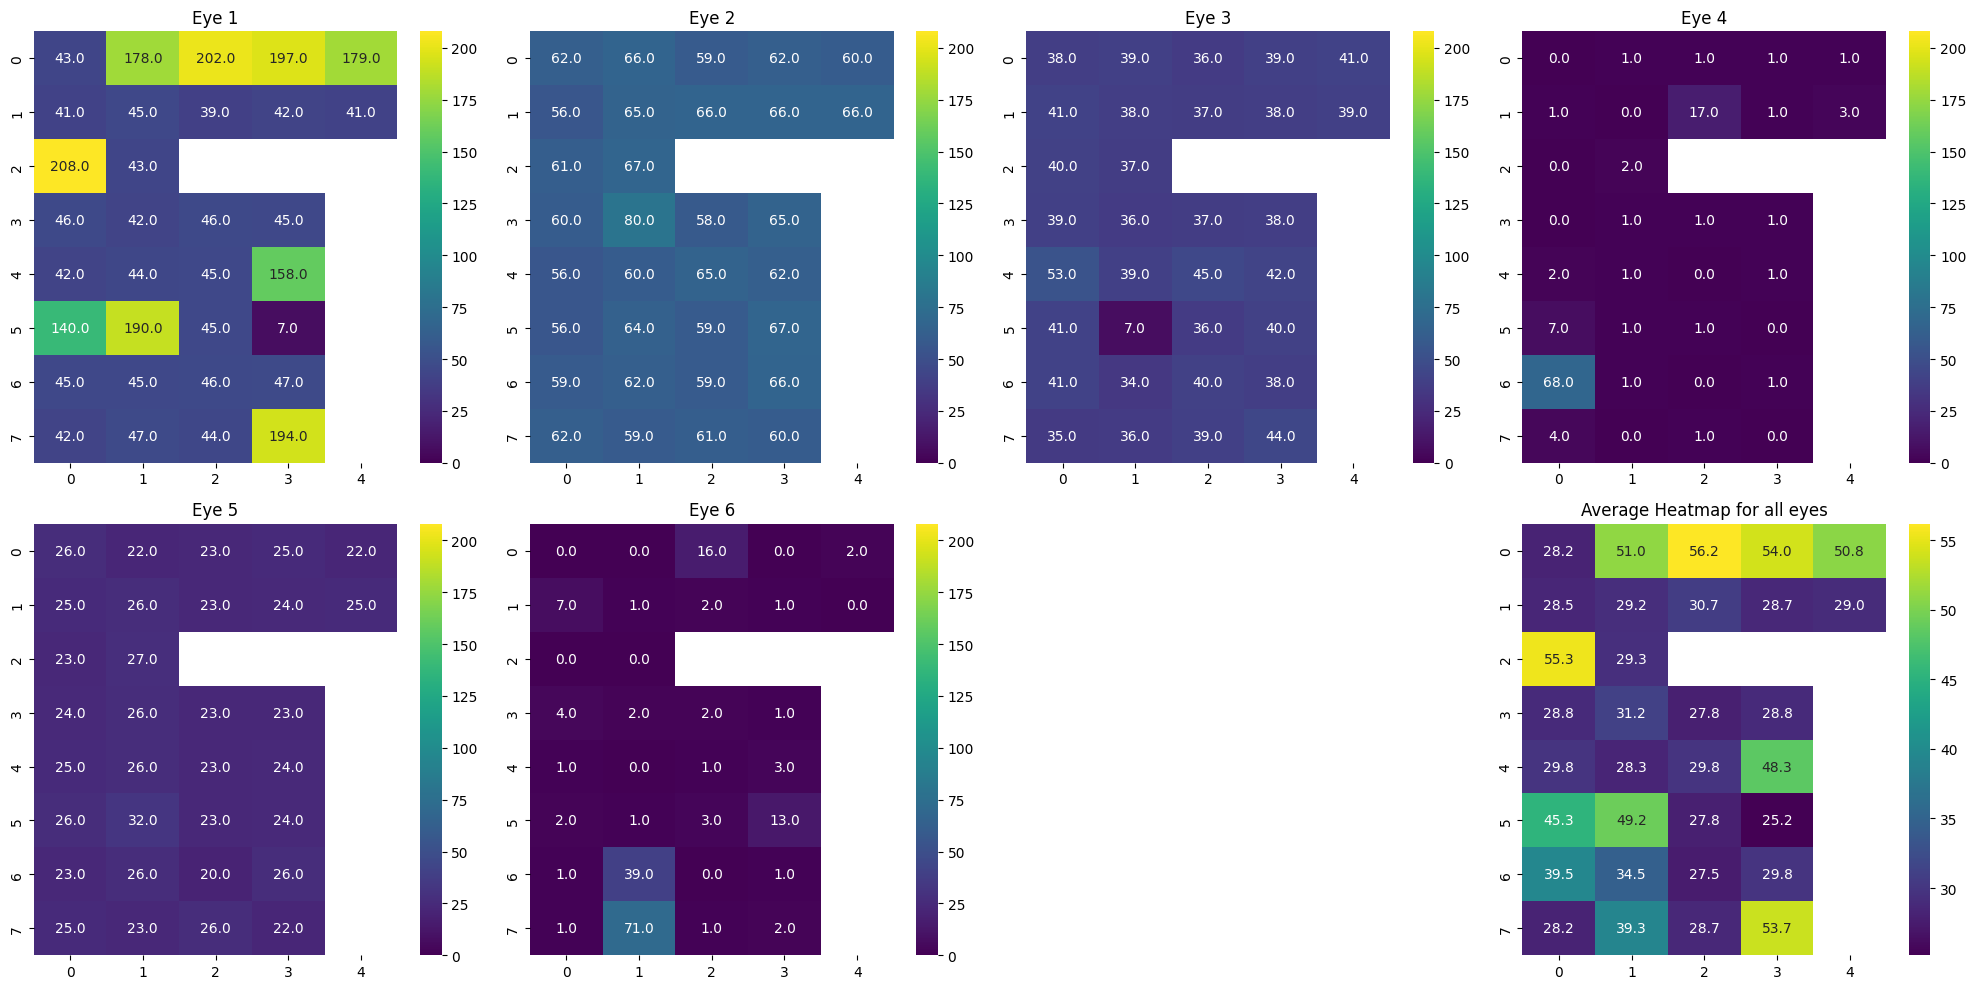

In [ ]:
plot_heatmap_spike_count(spike_counts_all_eyes)

Heat map of spike count using true data

<ipython-input-10-a8a372f6c6c7>:22: RuntimeWarning: Mean of empty slice
  average_vector = np.nanmean(spike_counts_all_eyes, axis=0)


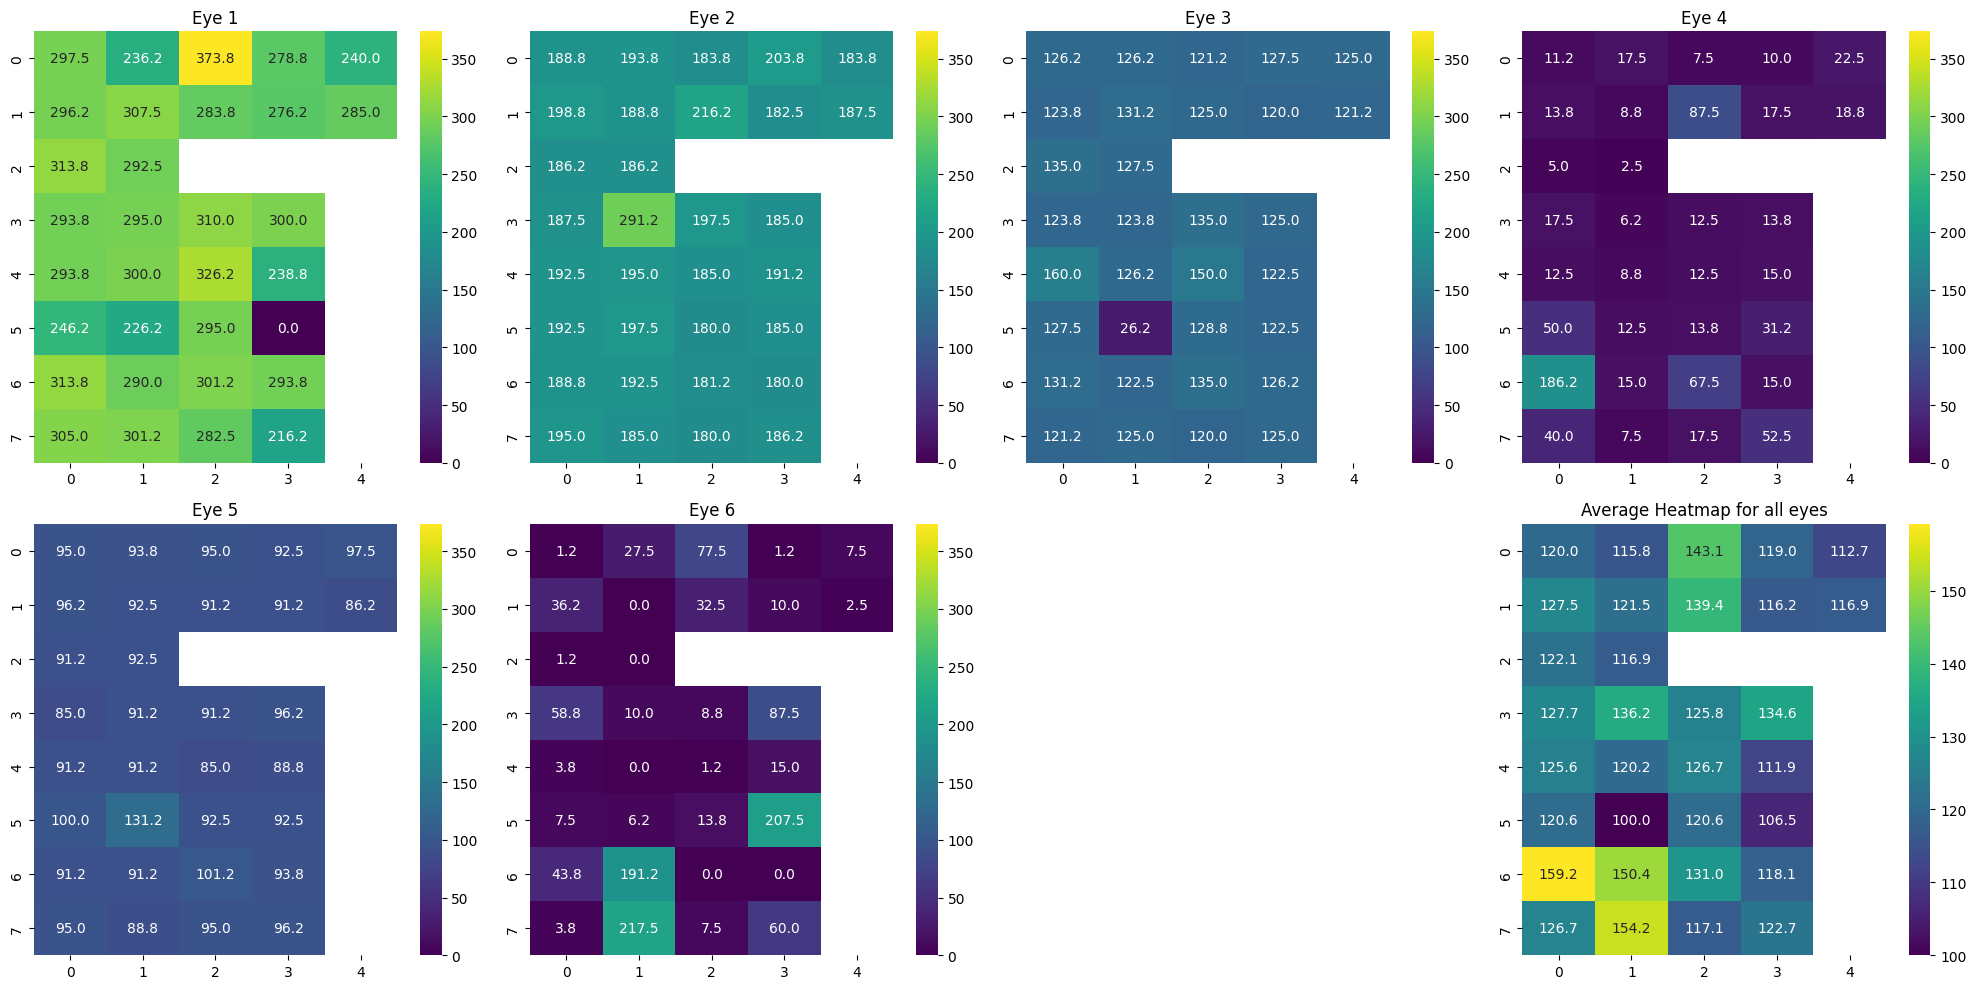

In [ ]:
# Inspection of true spike count
variable_name = 'true_Spike_counts_pr_sec_mat_STIMULATION'
spike_counts_all_eyes_true = data_processed[variable_name]
plot_heatmap_spike_count(spike_counts_all_eyes_true.T)

### Savitzky-Golay Filter

In [ ]:
# Defining which eye (first row) and extracting the first channel
eye_data = df_processed.iloc[0]
first_channel = eye_data[0]

# Extract the first section of the first channel
first_section = first_channel[:, 0]  # Assuming sections are along the columns

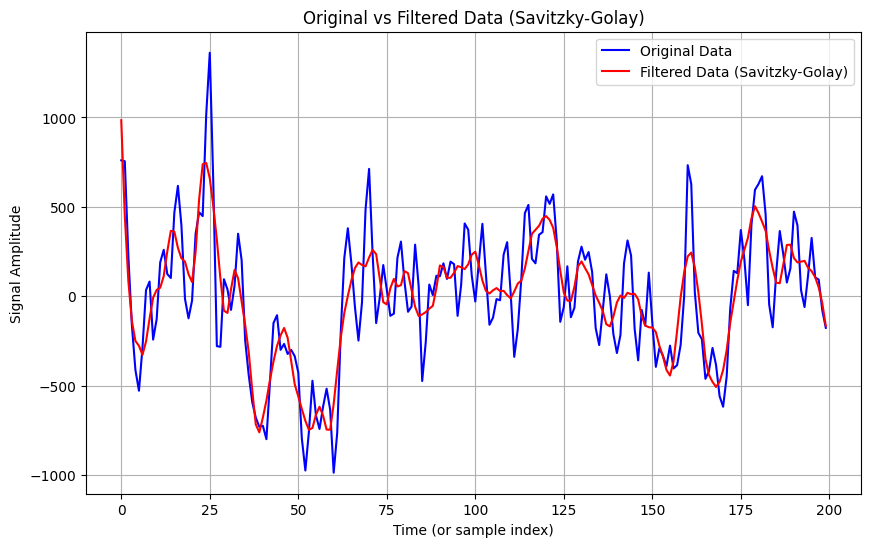

In [ ]:
# Savitzky-Golay filter parameters
window_length = 11  # The length of the filter window (must be odd)
polyorder = 3       # The order of the polynomial used to fit the samples

# Apply Savitzky-Golay filter
filtered_section = savgol_filter(first_section[:200], window_length, polyorder)

# Plotting original vs filtered data
plt.figure(figsize=(10, 6))
plt.plot(first_section[:200], label='Original Data', color='blue')
plt.plot(filtered_section, label='Filtered Data (Savitzky-Golay)', color='red')
plt.title('Original vs Filtered Data (Savitzky-Golay)')
plt.xlabel('Time (or sample index)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()


## Subraction of SA

Load SA data

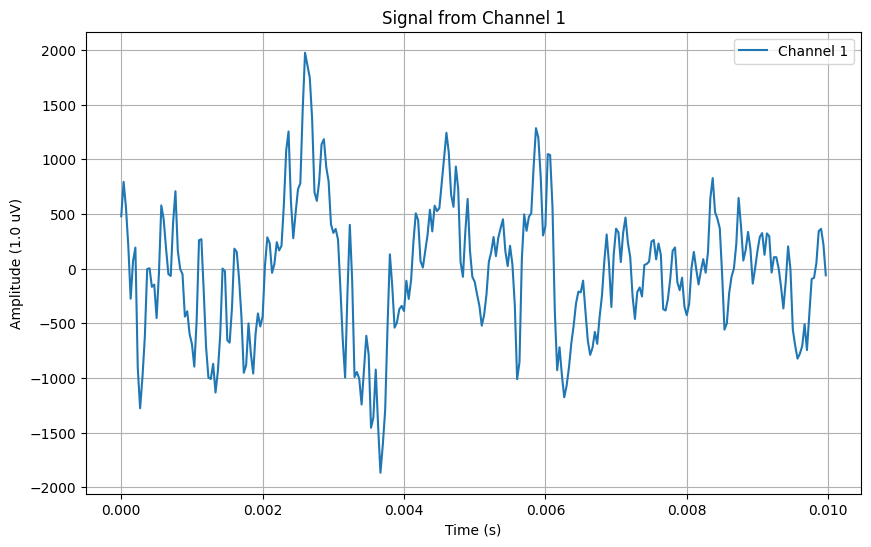

In [ ]:
# Plot the first channel's data (assuming each channel is one column)
channel_index = 0  # Change this to plot a different channel
data = analog_signal_SA[:, channel_index].magnitude  # Extract data for the selected channel
time_vector = analog_signal_SA.times  # Time vector for the x-axis

data_points_start = 0
data_points_end = 300

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_vector[:data_points_end], data[:data_points_end], label=f'Channel {channel_index + 1}')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({analog_signal.units})')
plt.title('Signal from Channel 1')
plt.legend()
plt.grid(True)
plt.show()

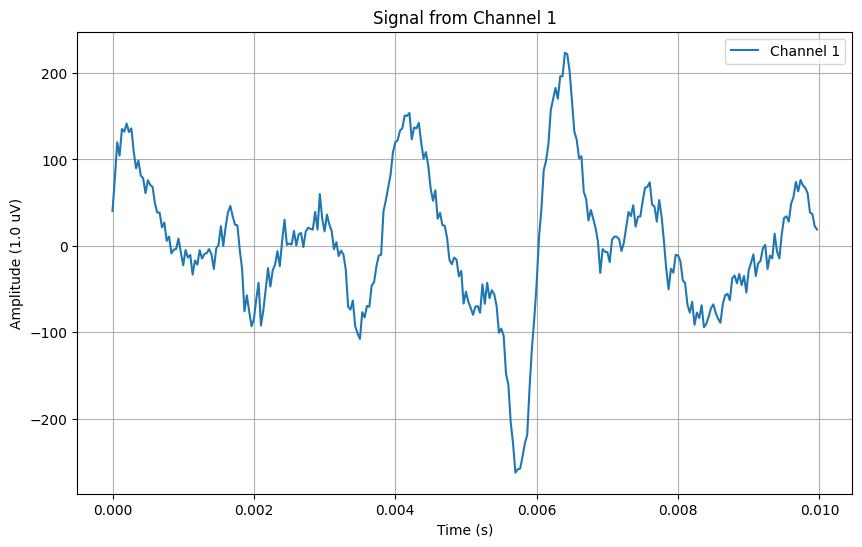

In [ ]:
# Plot the first channel's data (assuming each channel is one column)
channel_index = 0  # Change this to plot a different channel
data = analog_signal_TTX[:, channel_index].magnitude  # Extract data for the selected channel
time_vector = analog_signal_TTX.times  # Time vector for the x-axis

data_points_start = 0
data_points_end = 300

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_vector[:data_points_end], data[:data_points_end], label=f'Channel {channel_index + 1}')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({analog_signal.units})')
plt.title('Signal from Channel 1')
plt.legend()
plt.grid(True)
plt.show()

Overlay of both

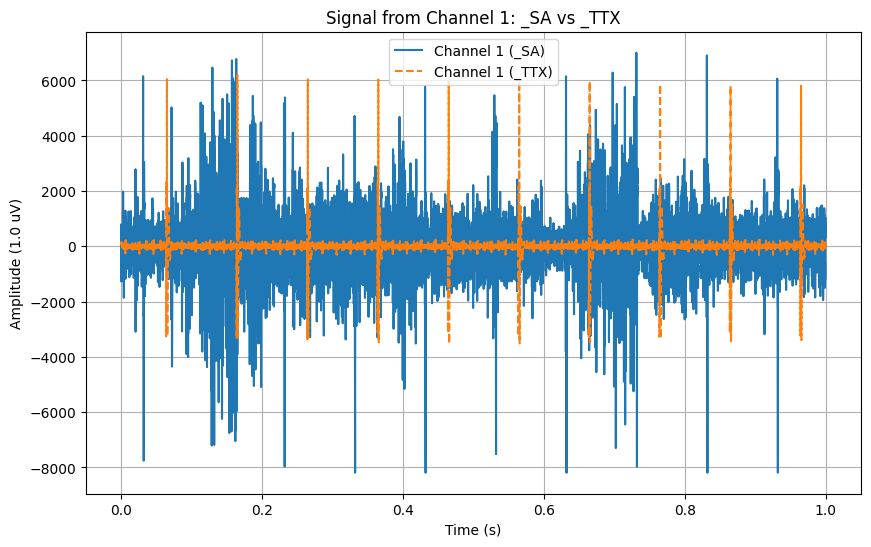

In [ ]:
# Plot the first channel's data from analog_signal_SA
channel_index = 0  # You can change this to plot a different channel
data_SA = analog_signal_SA[:, channel_index].magnitude  # Extract data for the selected channel from analog_signal_SA
data_TTX = analog_signal_TTX[:, channel_index].magnitude  # Extract data for the selected channel from analog_signal_TTX
time_vector = analog_signal_SA.times  # Time vector for the x-axis

data_points_start =
data_points_end = 30000

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the _SA data
plt.plot(time_vector[:data_points_end], data_SA[:data_points_end], label=f'Channel {channel_index + 1} (_SA)')

# Plot the _TTX data
plt.plot(time_vector[:data_points_end], data_TTX[:data_points_end], label=f'Channel {channel_index + 1} (_TTX)', linestyle='--')

# Set plot labels and title
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({analog_signal_SA.units})')
plt.title('Signal from Channel 1: _SA vs _TTX')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()